## Classifying From Tabular Data

In [87]:
# To classify tabular data we use fastai.tabular
from fastai.tabular.all import * 
import matplotlib.pyplot as plt
import numpy
import random
import unittest

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter


In [92]:
writer = SummaryWriter('runs/testing_01')

## Reading Data

In [3]:
# Path to data set
# Test data get partitioned into a separate file already now
from pathlib import Path
data_path = Path('./data/mecs/MECS_2-Phase-Steels.csv')

In [11]:
# Reading CSV file containing training and validation data
import pandas as pd
dataframe = pd.read_csv(data_path, sep=';')

# Looking at the first data
print(dataframe.info())
dataframe.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10735 entries, 0 to 10734
Columns: 107 entries, class to std. convexity
dtypes: float64(106), object(1)
memory usage: 8.8+ MB
None


,class,equiv. diameter,major axis length,minor axis length,perimeter,equiv. radius,max feret diameter,min feret diameter,mean feret diameter,convex perimeter,...,std. relativ area,std. convex area/filled area,std. axial ratio,std. aspect ratio,std. roundness,std. circularity,std. sphericity,std. convex per./filled per.,std. form factor,std. convexity
0,category_3,15.225748,11.478270,6.516211,101.586092,7.612874,28.476331,14.601479,21.538905,69.846721,...,0.002630,0.360265,0.247471,0.172865,0.167522,0.150141,0.991127,0.257917,0.254766,0.725854
1,category_3,1.151113,0.974243,0.385487,5.609659,0.575557,2.580962,0.888856,1.734909,5.555157,...,0.193671,0.345320,0.108488,0.097143,0.104520,0.107560,0.357665,0.126119,0.195196,0.270121
2,category_3,1.450391,1.068283,0.524281,5.629028,0.725196,2.312959,1.144310,1.728635,5.545392,...,0.102618,0.441363,0.205836,0.167468,0.075052,0.079354,0.199565,0.134383,0.116518,0.255049
3,category_3,3.561641,2.350421,1.400185,13.099335,1.780821,5.162738,3.039382,4.101060,12.632860,...,0.040841,0.347140,0.234101,0.159523,0.160860,0.144939,1.299666,0.328635,0.253970,1.025188
4,category_3,6.676158,5.226249,2.784733,35.279133,3.338079,12.536480,6.907373,9.721926,30.297397,...,0.009716,0.257991,0.253047,0.162753,0.156650,0.134192,1.073103,0.273935,0.238783,0.793738


## Data Loading and Encoding 

In [74]:
batch_size = 4
n_features = len(dataframe.columns)-1

def extract_numpy_from_df( dataframe, y_column ):
    X = dataframe.drop(columns=dataframe.columns[y_column]).to_numpy()
    Y = dataframe.iloc[:,y_column].to_numpy()

    return X,Y

def clean_data( dataframe ):
    dataframe.dropna(inplace=True)
    if dataframe.shape[0] < 100:
        raise ValueError("Data set too small after cleaning, less than 100 rows") 

    return dataframe

    
def get_validation_and_training_indices( dataset_length ):
    random.seed(42)
    indices_train = random.sample( range( dataset_length ), int( dataset_length * 0.8 ) )
    indices_validation = list( set(range( dataset_length )) - set(indices_train) )
    
    return indices_train,indices_validation

def normalize( X ):
    if X.std() == 0:
        raise ZeroDivisionError("The data cant be normalized, the standard deviation is zero. Data is constant.")
    else:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
        return X


def hot_1_encode( Y, codes ):
    Y_encoded = numpy.zeros( (Y.shape[0], len(codes)) )
    for i in range( Y.shape[0] ):
        Y_encoded[i][codes[Y[i]]] = 1
    
    return Y_encoded

def create_batch( permutation, batch_no, batch_size, X ):
    x_batch = torch.zeros( [ batch_size, X.shape[1] ], dtype=torch.float32 )
    for i in range( batch_size ):
        x_batch[i] = torch.tensor( X[ permutation[batch_no*batch_size + i] ] )
    
    return x_batch

codes = { 'category_1' : 0, 'category_2' : 1, 'category_3' : 2 }

dataframe = clean_data( dataframe )
X,Y = extract_numpy_from_df( dataframe, 0 )

indices_train,indices_validation = get_validation_and_training_indices( X.shape[0] )

X   = normalize( X )
Y   = hot_1_encode( Y, codes )

In [75]:
class TestNotebook(unittest.TestCase):

    def test_clean_data(self):
        data_too_small = pd.DataFrame({'A': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})

        data_with_nan = pd.DataFrame({'Value': np.random.randn(200)})
        nan_indices = np.random.choice(data_with_nan.index, size=20, replace=False)  # Choose 20 indices to be NaN
        data_with_nan.loc[nan_indices, 'Value'] = np.nan
        
        self.assertRaises(ValueError, clean_data,data_too_small)
        self.assertEqual(clean_data(data_with_nan).shape[0], 180)
        

    def test_extract_numpy_from_df(self):
        df = pd.DataFrame({'A': [1, 2, 3, 4, 5], 'B': [6, 7, 8, 9, 10], 'C': [11, 12, 13, 14, 15], 'D': [16, 17, 18, 19, 20]})
        X,Y = extract_numpy_from_df(df, 2)

        self.assertEqual(X.shape, (5,3))
        self.assertEqual(Y.shape[0], 5)
        self.assertEqual(Y[0], 11)

        X,Y = extract_numpy_from_df(df, 0)
        self.assertEqual(X.shape, (5,3))
        self.assertEqual(Y.shape[0], 5)
        self.assertEqual(Y[0], 1)

    def test_normalize(self):
        X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
        X = normalize(X)
        self.assertAlmostEqual(X.mean(), 0)
        self.assertAlmostEqual(X[1].mean(), 0)
        
        X = np.array([np.ones(5)])
        self.assertRaises(ZeroDivisionError, normalize, X)

    def test_hot_1_encode(self):
        Y = np.array(['category_1', 'category_2', 'category_3', 'category_1', 'category_2'])
        Y_encoded = hot_1_encode(Y, codes)

        self.assertEqual(Y_encoded.shape, (5, 3))
        self.assertEqual(Y_encoded[0][0], 1)
        self.assertEqual(Y_encoded[1][1], 1)
        self.assertEqual(Y_encoded[2][2], 1)
        self.assertEqual(Y_encoded[3][0], 1)
        self.assertEqual(Y_encoded[4][1], 1)
    
    def test_get_validation_and_training_indices(self):
        indices_train, indices_validation = get_validation_and_training_indices(100)
        self.assertEqual(len(indices_train), 80)
        self.assertEqual(len(indices_validation), 20)
        self.assertEqual(set(indices_train).intersection(set(indices_validation)) == set(), True)

    def test_create_batch(self):
        permutation = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
        X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12], [13, 14, 15], [16, 17, 18], [19, 20, 21], [22, 23, 24], [25, 26, 27], [28, 29, 30]])
        x_batch = create_batch(permutation, 1, 4, X)
        
        self.assertEqual(x_batch.shape, (4, 3))
        self.assertEqual(x_batch[0][0], 13)
        self.assertEqual(x_batch[1][1], 17)
        self.assertEqual(x_batch[2][2], 21)
        self.assertEqual(x_batch[3][0], 22)

unittest.main(argv=[''], verbosity=2, exit=False)


test_clean_data (__main__.TestNotebook) ... ok
test_create_batch (__main__.TestNotebook) ... ok
test_extract_numpy_from_df (__main__.TestNotebook) ... ok
test_get_validation_and_training_indices (__main__.TestNotebook) ... ok
test_hot_1_encode (__main__.TestNotebook) ... ok
test_normalize (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 6 tests in 0.025s

OK


## Creating a Network Architecture

In [100]:
def create_model( n_in, n_hidden, n_out ):
    layers = []
    
    # Input layer to first hidden layer
    layers.append(nn.Linear(n_in, n_hidden[0]))
    layers.append(nn.ReLU())
    
    # Adding subsequent hidden layers
    for i in range(1, len(n_hidden)):
        layers.append(nn.Linear(n_hidden[i-1], n_hidden[i]))
        layers.append(nn.ReLU())
    
    # Output layer
    layers.append(nn.Linear(n_hidden[-1], n_out))
    
    # Create the sequential model
    model = nn.Sequential(*layers)
    return model

model = create_model(X.shape[1], [50, 25], Y.shape[1])

In [101]:
print(model)

Sequential(
  (0): Linear(in_features=106, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=25, bias=True)
  (3): ReLU()
  (4): Linear(in_features=25, out_features=3, bias=True)
)


## Training Loop

In [102]:
def accuracy_metric( y, y_hat ):
    y     = torch.argmax(y, dim=1).to(torch.float32)
    y_hat = torch.argmax(y_hat, dim=1).to(torch.float32)
    difference = y_hat-y
    return 1.0 - torch.mean( torch.abs( difference ) ).item() 

def train_one_epoch( epoch_index, indices_train, X, Y, optimizer, loss_fn, batch_size ):
    no_iterations = int( len(indices_train) / batch_size )
    losses           = []
    accuracies       = []
    
    for batch_no in range( no_iterations ):
        x_batch = create_batch( indices_train, batch_no, batch_size, X )
        y_batch = create_batch( indices_train, batch_no, batch_size, Y )
        
        optimizer.zero_grad()
        y_hat = model( x_batch )
        loss = loss_fn( y_hat, torch.argmax(y_batch, dim=1) ) # CrossEntropyLoss expects the class index, not the one-hot encoding
        loss.backward()
        optimizer.step()
        
        accuracy = accuracy_metric( y_batch, y_hat )
        losses.append( loss.item() )
        accuracies.append( accuracy )

    return losses, accuracies

optimizer = torch.optim.Adam( params = model.parameters(), lr=0.001 )
loss_fn   = torch.nn.CrossEntropyLoss()

losses           = []
accuracies       = []
n_epochs = 50
for i in range (n_epochs):
    metrics = train_one_epoch( i, indices_train, X, Y, optimizer, loss_fn, 32 )
    loss_per_epoch, accuracy_per_epoch = metrics
    losses = losses + loss_per_epoch
    accuracies = accuracies + accuracy_per_epoch
    print("epoch",i,"/",n_epochs,"accuracy",accuracy_per_epoch[-1])

epoch 0 / 50 accuracy 0.875
epoch 1 / 50 accuracy 0.96875
epoch 2 / 50 accuracy 0.96875
epoch 3 / 50 accuracy 1.0
epoch 4 / 50 accuracy 1.0
epoch 5 / 50 accuracy 1.0
epoch 6 / 50 accuracy 1.0
epoch 7 / 50 accuracy 1.0
epoch 8 / 50 accuracy 1.0
epoch 9 / 50 accuracy 1.0
epoch 10 / 50 accuracy 1.0
epoch 11 / 50 accuracy 1.0
epoch 12 / 50 accuracy 1.0
epoch 13 / 50 accuracy 1.0
epoch 14 / 50 accuracy 1.0
epoch 15 / 50 accuracy 1.0
epoch 16 / 50 accuracy 1.0
epoch 17 / 50 accuracy 1.0
epoch 18 / 50 accuracy 1.0
epoch 19 / 50 accuracy 1.0
epoch 20 / 50 accuracy 1.0
epoch 21 / 50 accuracy 0.96875
epoch 22 / 50 accuracy 0.96875
epoch 23 / 50 accuracy 0.96875
epoch 24 / 50 accuracy 1.0
epoch 25 / 50 accuracy 1.0
epoch 26 / 50 accuracy 1.0
epoch 27 / 50 accuracy 1.0
epoch 28 / 50 accuracy 1.0
epoch 29 / 50 accuracy 0.96875
epoch 30 / 50 accuracy 1.0
epoch 31 / 50 accuracy 0.96875
epoch 32 / 50 accuracy 1.0
epoch 33 / 50 accuracy 0.90625
epoch 34 / 50 accuracy 0.96875
epoch 35 / 50 accuracy 0.96

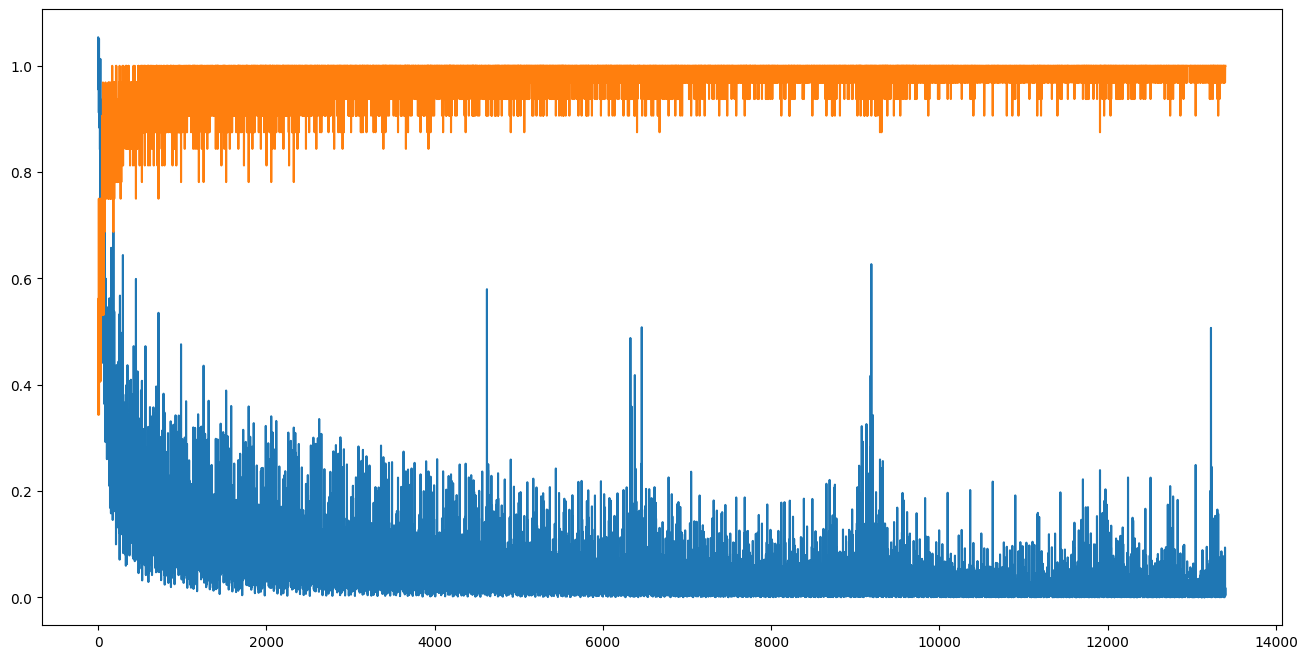

In [103]:
fig,axis = plt.subplots( 1,1, figsize=(16,8) )
axis.plot( losses )
axis.plot( accuracies )
plt.show()

## Hyper Parameter Tuning

Now, we experimentally determine optimal training parameters. You will need to organize your source
code to allow for the following experiments. Consider that a network is initialized with random values
only when the model is created. If training is interrupted and continued, weights and biases are preserved.
1. Find an optimal learning rate. Argue which rates you tested and how you determined an optimal
value.
2. Find an optimal learning batch size. Argue which batch sizes you tested and how you determined
an optimal value.
3. Find an optimal network architecture (number of layers and nuber of features for each layer). Argue
which architectures you tested and how you determined an optimal setup.
I needed the following time to complete the task:



In [93]:
def validate_one_epoch( epoch_index, indices_val, X, Y, model, loss_fn, batch_size ):
    no_val_batches = int( len(indices_val) / batch_size )
    losses = []
    accuracies = []
    
    for batch_no in range( no_val_batches ):
        x = create_batch( indices_val, batch_no, batch_size, X )
        y = create_batch( indices_val, batch_no, batch_size, Y )
        
        with torch.no_grad():
            y_pred = model( x )
            loss = loss_fn( y_pred, torch.argmax(y, dim=1) )
            accuracy = accuracy_metric( y, y_pred )
            losses.append( loss.item() )
            accuracies.append( accuracy )
    
    return np.mean( losses ), np.mean( accuracies )


for i in range (n_epochs):
    loss, accuracy = validate_one_epoch( i, indices_validation, X, Y, model, loss_fn, 32 )
    print("epoch",i,"/",n_epochs,"accuracy",accuracy)

epoch 0 / 50 accuracy 0.9542910447761194
epoch 1 / 50 accuracy 0.9542910447761194
epoch 2 / 50 accuracy 0.9542910447761194
epoch 3 / 50 accuracy 0.9542910447761194
epoch 4 / 50 accuracy 0.9542910447761194
epoch 5 / 50 accuracy 0.9542910447761194
epoch 6 / 50 accuracy 0.9542910447761194
epoch 7 / 50 accuracy 0.9542910447761194
epoch 8 / 50 accuracy 0.9542910447761194
epoch 9 / 50 accuracy 0.9542910447761194
epoch 10 / 50 accuracy 0.9542910447761194
epoch 11 / 50 accuracy 0.9542910447761194
epoch 12 / 50 accuracy 0.9542910447761194
epoch 13 / 50 accuracy 0.9542910447761194
epoch 14 / 50 accuracy 0.9542910447761194
epoch 15 / 50 accuracy 0.9542910447761194
epoch 16 / 50 accuracy 0.9542910447761194
epoch 17 / 50 accuracy 0.9542910447761194
epoch 18 / 50 accuracy 0.9542910447761194
epoch 19 / 50 accuracy 0.9542910447761194
epoch 20 / 50 accuracy 0.9542910447761194
epoch 21 / 50 accuracy 0.9542910447761194
epoch 22 / 50 accuracy 0.9542910447761194
epoch 23 / 50 accuracy 0.9542910447761194
ep